# Assignment 2: Voting Visualized

## Deadline

Oct. 24th

## Important notes

- Make sure you push on GitHub your notebook with all the cells already evaluated.
- Note that maps do not render in a standard Github environment. You should export them to HTML and link them in your notebook.
- Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you implemented.
- Please write all your comments in English, and use meaningful variable names in your code.
- Your repo should have a single notebook (plus the data files necessary) in the master branch. If there are multiple notebooks present, we will not grade anything. 

## Background


* Are you curious to know what the political leanings of the people of Switzerland are?
* Do you wake up in a cold sweat, wondering which party won the last cantonal parliament election in Vaud?
* Are you looking to learn all sorts of visualizations, including maps, in Python?

If your answer to any of the above is yes, this assignment is just right for you. Otherwise, it's still an assignment, so we're terribly sorry.

The chief aim of this assignment is to familiarize you with visualizations in Python, particularly maps, and also to give you some insight into how visualizations are to be interpreted. The data we will use is the data on Swiss cantonal parliament elections from 2007 to 2018, which contains, for each cantonal election in this time period, the voting percentages for each party and canton.

For the visualization part, install [Folium](Folium) (_Hint: it is not available in your standard Anaconda environment, therefore search on the Web how to install it easily!_). Folium's README comes with very clear examples, and links to their own iPython Notebooks -- make good use of this information. For your own convenience, in this same directory you can already find one TopoJSON file, containing the geo-coordinates of the cantonal borders of Switzerland.

One last, general reminder: back up any hypotheses and claims with data, since this is an important aspect of the course.

In [1]:
# Put your imports here.
import numpy as np
import pandas as pd
import json
import folium
import os
import re
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
data_folder = './data/'
maps_folder = './map/'

## Task 1: Cartography and census

__A)__ Display a Swiss map that has cantonal borders as well as the national borders. We provide a TopoJSON `data/ch-cantons.topojson.json` that contains the borders of the cantons.

__B)__ Take the spreadsheet `data/communes_pop.xls`, collected from [admin.ch](https://www.bfs.admin.ch/bfs/fr/home/statistiques/catalogues-banques-donnees/tableaux.assetdetail.5886191.html), containing population figures for every commune. You can use [pd.read_excel()](https://pandas.pydata.org/pandas-docs/version/0.20/generated/pandas.read_excel.html) to read the file and to select specific sheets. Plot a histogram of the population counts and explain your observations. Do not use a log-scale plot for now. What does this histogram tell you about urban and rural communes in Switzerland? Are there any clear outliers on either side, and if so, which communes?

__C)__ The figure below represents 4 types of histogram. At this stage, our distribution should look like Fig.(a). A common way to represent [power-laws](https://en.wikipedia.org/wiki/Power_law) is to use a histogram using a log-log scale  -- remember: the x-axis of an histogram is segmented in bins of equal sizes and y-values are the average of each bin. As shown in Fig.(b), small bins sizes might introduce artifacts. Fig.(b) and Fig.(c) are examples of histograms with two different bin sizes. Another great way to visualize such distribution is to use a cumulative representation, as show in Fig.(d), in which the y-axis represents the number of data points with values greater than y.  
  
Create the figures (b) and (d) using the data extracted for task 1B. For Fig.(b), represent two histograms using two different bin sizes and provide a brief description of the results. What does this tell you about the relationship between the two variables, namely the frequency of each bin and the value (i.e. population in case of the communal data) for each bin?

<img src="plaw_crop.png" style="width: 600px;">
  
The figure is extracted from [this paper](https://arxiv.org/pdf/cond-mat/0412004.pdf) that contains more information about this family of distributions.

In [3]:
# Map creation passing the [Latitude, Longitude] arguments and selecting a starting zoom of 7.5 (zoom scale [0,10])
swiss_coord = [46.8182, 8.2275]
swiss_map = folium.Map(swiss_coord, zoom_start =7)

#Adding different kind of views to the map
kind_of_views = ['openstreetmap', "Stamen Terrain", "Stamen Toner", 'Mapbox Bright','cartodbpositron']
for view in kind_of_views:
    folium.TileLayer(view).add_to(swiss_map)
    
# Now we're going to add the Swiss and its cantons boundaries using the the json file

# Open the topojson file 
swiss_boundaries_path = os.path.join(data_folder, 'ch-cantons.topojson.json')
swiss_boundaries_data=json.load(open(swiss_boundaries_path))

folium.TopoJson(
    swiss_boundaries_data,
    'objects.cantons',
    name='topojson'
).add_to(swiss_map)

folium.LayerControl().add_to(swiss_map) #For adding all the differents layer to the LayerControl menu (Above left)
swiss_map

In [4]:
swiss_map.save(maps_folder + 'swiss_map.html')

In [5]:
communes_data_path = os.path.join(data_folder,'communes_pop.xls')
name_sheet = '2017'
communes_data = pd.read_excel(communes_data_path,
                              sheet_name=name_sheet,
                              usecols="A:L", #only import the columns with data 
                              header = [3,4,5], #list of rows (0-index) to use as headers (Unnamed:x_level_x == empty rows)
                              nrows= (2414-7), #only import the rows with data 
                              index_col=0) #using the column A as index for the data set

#Renaming the columns names in order to avoid Unnamed:x_level_x
columns_names = ["Etat de la population au 1 er janvier", 
                         "Naissance vivantes",
                         "Décès",
                         "Accroissement",
                         "Arrivées 1)",
                         "Departs",
                         "Solde migratoire",
                         "Divergences statistiques",
                         "Etat de la population au 31 décembre",
                         "variations en nombres absolus",
                         "variations en nombres en %"]
communes_data.columns= columns_names

In [6]:
communes_data.head(5)

,Etat de la population au 1 er janvier,Naissance vivantes,Décès,Accroissement,Arrivées 1),Departs,Solde migratoire,Divergences statistiques,Etat de la population au 31 décembre,variations en nombres absolus,variations en nombres en %
Suisse 2),8419550,87381,66971,20410,681011,635063,45948,-1778,8484130,64580,0.767024
- Zürich,1487969,17070,11076,5994,120593,108666,11927,-1544,1504346,16377,1.100628
>> Bezirk Affoltern,52904,517,310,207,4501,3862,639,21,53771,867,1.638817
......0001 Aeugst am Albis,1977,10,7,3,129,165,-36,-3,1941,-36,-1.820941
......0002 Affoltern am Albis,11900,128,93,35,1239,1029,210,1,12146,246,2.067227


In [7]:
#The columns that starts by "......" are the Name of the Switzerland's communes
#We created a new data set that only contains the communes data

communes_population = communes_data.filter(regex='^\.{6}.*', axis=0)
communes_population.head(5)

,Etat de la population au 1 er janvier,Naissance vivantes,Décès,Accroissement,Arrivées 1),Departs,Solde migratoire,Divergences statistiques,Etat de la population au 31 décembre,variations en nombres absolus,variations en nombres en %
......0001 Aeugst am Albis,1977,10,7,3,129,165,-36,-3,1941,-36,-1.820941
......0002 Affoltern am Albis,11900,128,93,35,1239,1029,210,1,12146,246,2.067227
......0003 Bonstetten,5435,47,25,22,374,322,52,3,5512,77,1.416743
......0004 Hausen am Albis,3571,27,20,7,298,217,81,5,3664,93,2.604313
......0005 Hedingen,3687,31,20,11,224,231,-7,3,3694,7,0.189856


We are gonna change the name of the indexes, deleting the "......000x" this can be represented as regex="\.{6}[0-9]{4}", then we only gonna work with the column "Etat de la population au 31 décembre"

In [8]:
communes_population.index = communes_population.index.str.replace('\.{6}[0-9]{4}', '')
communes_population = communes_population.iloc[:, [8]]

 First we plotted the histogram
 Second we have calculated the normal distribution of the data sets
 Third we have calculated the gamma distribution of the data sets
 The reason was to observe which of the distributions fit better with the histogram plots.
 We can see the gamma distribution describes better the amount of data behaviour

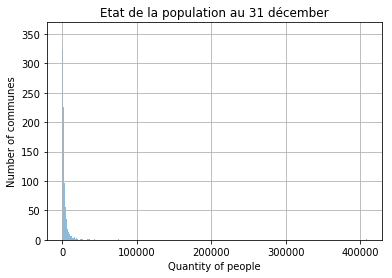

In [21]:
communes_population.hist(bins=1000, alpha=0.5)
plt.title('Etat de la population au 31 décember')
plt.xlabel("Quantity of people")
plt.ylabel("Number of communes")

plt.show()

# 1B

From the histogram we can tell that there are significantly more rural communes (i.e. communes with a small population count) than urban communes in Switzerland. In the histogram we can also see that there are outliers with a large count population. However, the histogram does not allow us to see if there are outliers for small count population communes.

From the plot below (using the log scale) we can observe that there are no outliers for the communes with a small population count.

Text(0,0.5,'Quantity of people')

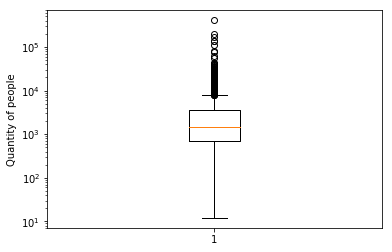

In [23]:
plt.boxplot(communes_population.values)
plt.yscale('log')
plt.ylabel("Quantity of people")


# 1C

In order to plot the Fig(b) and Fig(d) we decided to use the linear plots too, because with histogram one we couldn't obtain the required figures. First we change the scale value to y-axis as is shown in the Fig('Lin-log scale') and the result is quite similar to the Fig(b) so we can affirm that there is a power-law between the cantons and their amount of inhabitants.
For obtain the Fig(d) we changed the x-axis scale but we think is wrong do that.
And finally, we used hist plot to represent the acumulative plot of the data set.

Text(0.5,1,'Etat de la population au 31 décember')

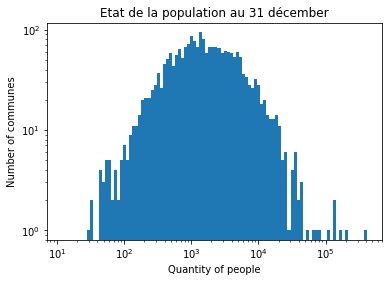

In [24]:
hist,bins,_ = plt.hist(communes_population.values, bins=100)

# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.cla()  #Clear the scale of the axis
plt.hist(communes_population.values, bins=logbins)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Number of communes')
plt.xlabel('Quantity of people')
plt.title("Etat de la population au 31 décember")

The data is normally distibuted around the medium sized cities with a population of the order of 10<sup>3</sup>. We observe the presence of large outliers that skew the data. These cities correspond to the very large cities of switzerland with population of order 10<sup>5</sup>

Text(0.5,1,'Etat de la population au 31 décember')

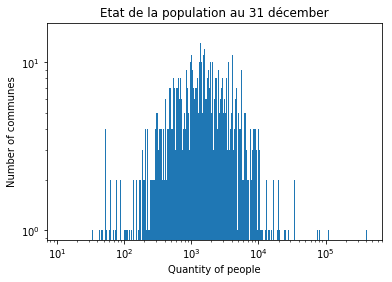

In [25]:
hist,bins,_ = plt.hist(communes_population.values, bins=1000)

# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.cla()
plt.hist(communes_population.values, bins=logbins)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Number of communes')
plt.xlabel('Quantity of people')
plt.title("Etat de la population au 31 décember")

By increasing the number of bins as shown below we can see that the distibution is not as clear as previously with the introduction of artifacts that reduce the readability of the plot

Text(0.5,1,'Etat de la population au 31 décember')

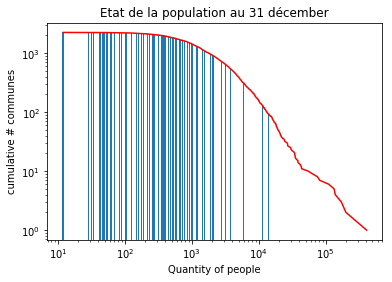

In [28]:
idx = np.sort(communes_population.iloc[:,0].values)
vals = list(range(1,len(idx)+1))
vals.reverse()
plt.plot(idx,vals,color="red")
plt.bar(idx,vals)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('cumulative # communes')
plt.xlabel('Quantity of people')
plt.title("Etat de la population au 31 décember")

We observe that the largest part of the cities have a population that is less than 10<sup>4</sup>. Only 100 cities have a population large that 10<sup>4</sup> which represents 5% of all the cities. The representation can be seen as a power log distribution as we have large values that are rare but not extremely rare. However, there are more medium sized cities that small ones which explains why the plots do not resemble the ones given in example.

## Task 2: Parties visualized

We provide a spreadsheet, `data/voters.xls`, (again) collected from [admin.ch](https://www.bfs.admin.ch/bfs/fr/home/statistiques/politique/elections/conseil-national/force-partis.assetdetail.217195.html), which contains the percentage of voters for each party and for each canton. For the following task, we will focus on the period 2014-2018 (the first page of the spreadsheet). Please report any assumptions you make regarding outliers, missing values, etc. Notice that data is missing for two cantons, namely Appenzell Ausserrhoden and Graubünden, and your visualisations should include data for every other canton.


__A)__ For the period 2014-2018 and for each canton, visualize, on the map, **the percentage of voters** in that canton who voted for the party [`UDC`](https://en.wikipedia.org/wiki/Swiss_People%27s_Party) (Union démocratique du centre). Does this party seem to be more popular in the German-speaking part, the French-speaking part, or the Italian-speaking part?

__B)__ For the same period, now visualize **the number of residents** in each canton who voted for UDC.

__C)__ Which one of the two visualizations above would be more informative in case of a national election with majority voting (i.e. when a party needs to have the largest number of citizens voting for it among all parties)? Which one is more informative for the cantonal parliament elections?

For part B, you can use the `data/national_council_elections.xslx` file ([guess where we got it from](https://www.bfs.admin.ch/bfs/fr/home/statistiques/politique/elections/conseil-national/participation.assetdetail.81625.html)) to have the voting-eligible population of each canton in 2015.

In [29]:
# loading the canton data
canton_geo_path = data_folder + 'ch-cantons.topojson.json'
geo_json_data = json.load(open(canton_geo_path))


In [30]:
# read the voting file
voting_data_file = os.path.join(data_folder, 'voters.xls') 
name_sheet = 'actuel (2014-2018)'
voting_data = pd.read_excel(voting_data_file,
    sheet_name=name_sheet,
    index_col=0, header=2,
    nrows=(36 - 2))

voting_data.head(5)

,Unnamed: 1,Année électorale 2),Participation,PLR 6),Unnamed: 5,PDC 7),Unnamed: 7,PS,Unnamed: 9,UDC,...,JB,Unnamed: 55,Front,Unnamed: 57,Grut,Unnamed: 59,Autres 11),Unnamed: 61,K,Total
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zurich,NaN,2015.0,32.652497,17.327820,NaN,4.878712,NaN,19.716444,NaN,30.023215,...,NaN,NaN,NaN,NaN,NaN,NaN,0.669707,NaN,NaN,100
Berne,NaN,2018.0,30.516313,11.717910,NaN,0.671415,NaN,22.328775,NaN,26.760869,...,NaN,NaN,NaN,NaN,NaN,NaN,0.912781,NaN,NaN,100
Lucerne,NaN,2015.0,38.741267,21.039516,NaN,30.862513,NaN,11.848915,NaN,24.115646,...,NaN,NaN,NaN,NaN,NaN,NaN,0.036129,NaN,NaN,100


In [32]:
# remove the rows that are empty
voting_data = voting_data[voting_data.index.notnull()]
# remove the columns that are empty
voting_data = voting_data.drop(voting_data.columns[voting_data.columns.str.contains('unnamed', case=False)],
           axis=1)
voting_data = voting_data.dropna(how='all', axis=1)
#change the format of some column names that end with x)
voting_data.columns = voting_data.columns.str.replace('[0-9]\)$', '')

voting_data.head(5)

,Année électorale,Participation,PLR,PDC,PS,UDC,Dém.,PLS,AdI,PEV,...,PSL,Lega,MCR,LS,JB,Front,Grut,Autres 1,K,Total
Zurich,2015.0,32.652497,17.327820,4.878712,19.716444,30.023215,NaN,NaN,NaN,4.271767,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.669707,NaN,100
Berne,2018.0,30.516313,11.717910,0.671415,22.328775,26.760869,NaN,NaN,NaN,6.172897,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.912781,NaN,100
Lucerne,2015.0,38.741267,21.039516,30.862513,11.848915,24.115646,NaN,NaN,NaN,0.199143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.036129,NaN,100
Uri 1),2016.0,61.989056,26.856698,31.298814,12.984966,24.053191,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.428270,NaN,100
Schwytz,2016.0,37.747088,21.628996,27.167707,12.925363,33.115090,NaN,NaN,NaN,0.304428,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.513578,NaN,100


In [37]:
def formatCantonIndex(df):
    # removing accents from name of cantons
    df.index=df.index.str.replace("â", "a")
    df.index=df.index.str.replace("è", "e")
    df.index=df.index.str.replace("-", " ")
    
    #removing numbers from name of cantons
    df.index = df.index.str.replace('[0-9].*$', '')

In [38]:
formatCantonIndex(voting_data)

In [39]:
voting_data.sort_index()

,Année électorale,Participation,PLR,PDC,PS,UDC,PLS,PEV,PCS,PVL,...,PSA,PES,AVF,Sol.,DS,UDF,Lega,MCR,Autres 1,Total
Appenzell Rh. Ext.,2015.0,36.111260,35.526730,6.037578,11.475833,16.281936,NaN,2.149373,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.528551,100
Appenzell Rh. Int.,2015.0,36.111260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,…
Argovie,2016.0,32.805153,15.997428,12.103790,18.918913,31.937510,NaN,4.048430,NaN,5.259593,...,NaN,7.051238,NaN,NaN,NaN,1.770212,NaN,NaN,0.207173,100
Bale Campagne,2015.0,33.845621,19.029750,9.617786,21.995307,26.741611,NaN,5.365701,NaN,4.413096,...,NaN,9.577718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100
Bale Ville,2016.0,41.659853,9.230169,5.852947,32.481128,14.297919,13.776873,3.468381,NaN,4.308932,...,NaN,13.350981,NaN,NaN,NaN,0.114509,NaN,NaN,2.587566,100
Berne,2018.0,30.516313,11.717910,0.671415,22.328775,26.760869,NaN,6.172897,NaN,6.914731,...,0.681873,10.104467,0.495841,NaN,0.179432,3.710624,NaN,NaN,0.912781,100
Fribourg,2016.0,39.302102,18.165508,23.707027,23.584309,19.717606,NaN,NaN,3.644715,2.450731,...,NaN,4.514650,NaN,NaN,NaN,NaN,NaN,NaN,3.973469,100
Geneve,2018.0,37.719442,25.183926,10.712970,15.299358,7.315683,NaN,NaN,NaN,1.602925,...,NaN,13.157683,NaN,4.590890,NaN,NaN,NaN,9.432303,10.090401,100
Glaris,2018.0,29.489675,18.392812,9.400847,12.750408,25.275361,NaN,NaN,NaN,5.957381,...,NaN,12.351048,NaN,NaN,NaN,NaN,NaN,NaN,1.803643,100
Grisons,2018.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,…


In [40]:
# read the cantons file
canton_data_file = os.path.join(data_folder, 'cantons.csv')
canton_data = pd.read_csv(canton_data_file)
canton_data.head(5)

,Code,Canton of,Since,Capital,Population,GDP percapita (2014)[16]in CHF,Area (km2),Density (per km2)[Note 4],No. munic.,Official languages
0,ZH,Zürich,1351,Zürich,"1,504,346[17]","96,411","1,729",701,168,German
1,BE,Bern,1353,Bern,"1,031,126[18]","76,307","5,960",158,352,"German, French"
2,LU,Luzern,1332,Lucerne,"403,397[19]","65,119","1,494",233,83,German
3,UR,Uri,1291,Altdorf,"36,145[20]","51,332","1,077",33,20,German
4,SZ,Schwyz,1291,Schwyz,"155,863[21]","58,788",908,143,30,German


In [41]:
# remove accents from the name of the cantons
# from canton_data
canton_data['Canton of'] = canton_data['Canton of'].str.replace("ü", "u")
canton_data['Canton of'] = canton_data['Canton of'].str.replace("â", "a")
canton_data['Canton of'] = canton_data['Canton of'].str.strip()

In [42]:
canton_data['Canton of']

0                     Zurich
1                       Bern
2                     Luzern
3                        Uri
4                     Schwyz
5                   Obwalden
6                  Nidwalden
7                     Glarus
8                        Zug
9                   Fribourg
10                 Solothurn
11               Basel-Stadt
12          Basel-Landschaft
13              Schaffhausen
14    Appenzell Ausserrhoden
15     Appenzell Innerrhoden
16                St. Gallen
17                   Grisons
18                    Aargau
19                   Thurgau
20                    Ticino
21                      Vaud
22                    Valais
23                 Neuchatel
24                    Geneva
25                      Jura
Name: Canton of, dtype: object

In [43]:
# noticing that the cantons of the voting_data
# is in the same order as the cantons in the canton_data
# create a new numerical index for the voting_data
# so that we can simply just join the two data sets together
voting_data = voting_data.rename_axis('Canton Name').reset_index()

df = voting_data[['Canton Name', 'UDC']].join(
    canton_data[['Official languages', 'Code']]
)

df.head()

,Canton Name,UDC,Official languages,Code
0,Zurich,30.023215,German,ZH
1,Berne,26.760869,"German, French",BE
2,Lucerne,24.115646,German,LU
3,Uri,24.053191,German,UR
4,Schwytz,33.115090,German,SZ


In [44]:
# creating map
swiss_coord = [46.8182, 8.2275]
swiss_map = folium.Map(
    swiss_coord,
    tiles='cartodbpositron',
    zoom_start=7
)

# change NaN values to zero, so map does not 
# display those cantons as the 29-35% range
df.fillna(0, inplace=True)

# show layover for percentage of votes
swiss_map.choropleth(
    geo_data=geo_json_data,
    topojson='objects.cantons',
    data=df,
    columns=['Code', 'UDC'],
    key_on='feature.id',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Votes for UDC (%)'
)

swiss_map_name = 'CH_Election_Percentage.html'
swiss_map.save(maps_folder+swiss_map_name)

C:\Users\karee\Anaconda3\lib\site-packages\folium\folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


View the Election Percentage map: [here](map/CH_Election_Percentage.html)

Based on the map, it seems that this party (UDC) is most popular in the German speaking part. We assume that the size closest to Germany would be the German speaking part of Switzerland and that part of the map has the highest percentage of voters in the canton. We can verify this further by analyzing the percentages based on the language. As shown below, when we order the percentage of UDC votes by descending popularity, most of the German speaking cantons are at the top. While, most of the French and Italian speaking cantons are at the bottom.

In [46]:
# read the national council elections file
participation_file = os.path.join(data_folder, 'national_council_elections.xlsx')
name_sheet = '2015'
participation_data = pd.read_excel(participation_file,
    sheet_name=name_sheet,
    index_col=0, header=3,
    nrows=(35 - 4))

# removing empty rows
participation_data = participation_data[participation_data.index.notnull()]
# format participation_data, same as previously done with voting_data
formatCantonIndex(participation_data)
# remove total row
participation_data.drop('Total', inplace=True)
# remove trailing spaces for df and participation_data
participation_data.index = participation_data.index.str.strip()
# changing Saint-Gall to St. Gall
participation_data.rename(index={'Saint Gall': 'St. Gall'}, inplace=True)

participation_data

,Electeurs inscrits,Electeurs 2),Participation en %
Zurich,907623.0,428837.0,47.248362
Berne,729203.0,357770.0,49.063155
Lucerne,271143.0,138096.0,50.931059
Uri,26414.0,15091.0,57.132581
Schwytz,102145.0,54857.0,53.705027
Obwald,26244.0,15617.0,59.506935
Nidwald,30810.0,17971.0,58.328465
Glaris,26268.0,10890.0,41.457286
Zoug,74803.0,40200.0,53.741160
Fribourg,196027.0,92462.0,47.167992


In [47]:
# remove trailing spaces for df and participation_data
df['Canton Name'] = df['Canton Name'].str.strip()
df

,Canton Name,UDC,Official languages,Code
0,Zurich,30.023215,German,ZH
1,Berne,26.760869,"German, French",BE
2,Lucerne,24.115646,German,LU
3,Uri,24.053191,German,UR
4,Schwytz,33.115090,German,SZ
5,Obwald,24.532303,German,OW
6,Nidwald,25.916631,German,NW
7,Glaris,25.275361,German,GL
8,Zoug,23.631802,German,ZG
9,Fribourg,19.717606,"French, German",FR


In [50]:
# join voting_data with participation_data
udc_pop = participation_data[['Electeurs 2)']].merge(
    df, left_index=True,
    right_on='Canton Name',
    how='outer'
)
# using join outer, we can see that there are only 2 Cantons
# where we do not have data as expected
udc_pop

,Electeurs 2),Canton Name,UDC,Official languages,Code
0,428837.0,Zurich,30.023215,German,ZH
1,357770.0,Berne,26.760869,"German, French",BE
2,138096.0,Lucerne,24.115646,German,LU
3,15091.0,Uri,24.053191,German,UR
4,54857.0,Schwytz,33.115090,German,SZ
5,15617.0,Obwald,24.532303,German,OW
6,17971.0,Nidwald,25.916631,German,NW
7,10890.0,Glaris,25.275361,German,GL
8,40200.0,Zoug,23.631802,German,ZG
9,92462.0,Fribourg,19.717606,"French, German",FR


In [52]:
# create new column for population that voted for UDC
udc_pop = udc_pop.assign(population_UDC = lambda x: 
          round(x['Electeurs 2)']*(x['UDC']/100))/1000
)

udc_pop.head(5)

,Electeurs 2),Canton Name,UDC,Official languages,Code,population_UDC
0,428837.0,Zurich,30.023215,German,ZH,128.751
1,357770.0,Berne,26.760869,"German, French",BE,95.742
2,138096.0,Lucerne,24.115646,German,LU,33.303
3,15091.0,Uri,24.053191,German,UR,3.630
4,54857.0,Schwytz,33.115090,German,SZ,18.166


In [54]:
# creating map
swiss_coord = [46.8182, 8.2275]
swiss_map = folium.Map(
    swiss_coord,
    tiles='cartodbpositron',
    zoom_start=7
)

# map to show population
swiss_map.choropleth(
    geo_data=geo_json_data,
    topojson='objects.cantons',
    data=udc_pop,
    columns=['Code', 'population_UDC'],
    key_on='feature.id',
    fill_color='OrRd',
    fill_opacity=0.8, line_opacity=0.5,
    legend_name='Votes for UDC (in thousands)'
)

swiss_map.save(maps_folder+'CH_Election_Pop.html')

C:\Users\karee\Anaconda3\lib\site-packages\folium\folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


# C

View the Swiss Election Population map: [here](map/CH_Election_Pop.html)

The first map, which shows the percentages of the cantons who voted for UDC, would be more useful for cantonal parliament elections. It is more useful because it shows that within a Canton the percentage of people that had voted for UDC. For cantonal parliament election, the whole population of Switzerland does not matter, it only matters that the party has a majority vote in the canton.

Meanwhile the second map, which shows the population of people who voted for UDC, would be more informative for a national election. This way, the party can see where they should campaign more so that they can receive the most additional votes.

## Task 3: More socialism or more nationalism?

In this section, we focus on two parties that are representative of the left and the right on the Swiss political spectrum. You will propose a way to visualize their influence over time and for each canton.

__A)__ Take the two parties [`UDC`](https://en.wikipedia.org/wiki/Swiss_People%27s_Party) (Union démocratique du centre) and [`PS`](https://en.wikipedia.org/wiki/Social_Democratic_Party_of_Switzerland) (Parti socialiste suisse). For each canton, we define 'right lean' in a certain period as follows:

$$\frac{VoteShare_{UDC} - VoteShare_{PS}}{VoteShare_{UDC} + VoteShare_{PS}}$$  

Visualize the right lean of each canton on the map. What conclusions can you draw this time? Can you observe the [röstigraben](https://en.wikipedia.org/wiki/R%C3%B6stigraben) ?

__B)__ For each party, devise a way to visualize the difference between its 2014-2018 vote share (i.e. percentage) and its 2010-2013 vote share for each canton. Propose a way to visualize this evolution of the party over time, and justify your choices. There's no single correct answer, but you must reasonably explain your choices.

# A

In [56]:
voters = voting_data[["Canton Name", "UDC", "PS"]]
voters.head(5)

,Canton Name,UDC,PS
0,Zurich,30.023215,19.716444
1,Berne,26.760869,22.328775
2,Lucerne,24.115646,11.848915
3,Uri,24.053191,12.984966
4,Schwytz,33.115090,12.925363


In [57]:
voters = voters.assign(right_lean = lambda x: (x["UDC"]-x["PS"])/(x["UDC"]+x["PS"]))
voters.head(5)

,Canton Name,UDC,PS,right_lean
0,Zurich,30.023215,19.716444,0.207214
1,Berne,26.760869,22.328775,0.090286
2,Lucerne,24.115646,11.848915,0.341078
3,Uri,24.053191,12.984966,0.298833
4,Schwytz,33.115090,12.925363,0.438521


In [58]:
voters.fillna(0, inplace=True)
voters

,Canton Name,UDC,PS,right_lean
0,Zurich,30.023215,19.716444,0.207214
1,Berne,26.760869,22.328775,0.090286
2,Lucerne,24.115646,11.848915,0.341078
3,Uri,24.053191,12.984966,0.298833
4,Schwytz,33.115090,12.925363,0.438521
5,Obwald,24.532303,15.090867,0.238281
6,Nidwald,25.916631,4.470053,0.705789
7,Glaris,25.275361,12.750408,0.329381
8,Zoug,23.631802,9.250912,0.437339
9,Fribourg,19.717606,23.584309,-0.089296


In [59]:
voters = voters[['Canton Name', 'right_lean']].join(canton_data[[ 'Code']])
voters

,Canton Name,right_lean,Code
0,Zurich,0.207214,ZH
1,Berne,0.090286,BE
2,Lucerne,0.341078,LU
3,Uri,0.298833,UR
4,Schwytz,0.438521,SZ
5,Obwald,0.238281,OW
6,Nidwald,0.705789,NW
7,Glaris,0.329381,GL
8,Zoug,0.437339,ZG
9,Fribourg,-0.089296,FR


In [61]:
# creating map
swiss_coord = [46.8182, 8.2275]
swiss_map = folium.Map(
    swiss_coord,
    tiles='cartodbpositron',
    zoom_start=7
)

# map to show right_lean
swiss_map.choropleth(
    geo_data=geo_json_data,
    topojson='objects.cantons',
    data=voters,
    columns=['Code', 'right_lean'],
    key_on='feature.id',
    fill_color='PuOr',
    fill_opacity=0.8, line_opacity=0.5,
    legend_name='Right lean'
)

swiss_map.save(maps_folder+'CH_Right_Lean.html')

C:\Users\karee\Anaconda3\lib\site-packages\folium\folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


From the two maps above we can conclude that based on the right lean formula, the right-wing party is more popular in the german-speaking part of Switzerland, while the left-wing party is more popular in the french-speaking and italian-speaking part. It is possible to see the Röstigraben dividing the german and french, although the south of the french-speaking part is leaning towards the right.